# Train a AttentiveFP model for solubility prediction

In [ ]:
# # % matplotlib
# # inline
# import os
# from rdkit import Chem
# from rdkit import RDPaths
#
# import dgl
# import numpy as np
# import random
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader
# from torch.utils.data import Dataset
# # from dgl import model_zoo
# from dgllife.model import model_zoo
# # from dgllife.model.gnn import attentivefp
# from dgllife.utils import mol_to_complete_graph, mol_to_bigraph
#
# from dgllife.utils import atom_type_one_hot
# from dgllife.utils import atom_degree_one_hot
# from dgllife.utils import atom_formal_charge
# from dgllife.utils import atom_num_radical_electrons
# from dgllife.utils import atom_hybridization_one_hot
# from dgllife.utils import atom_total_num_H_one_hot
# from dgllife.utils import CanonicalAtomFeaturizer
# from dgllife.utils import CanonicalBondFeaturizer
# from dgllife.utils import ConcatFeaturizer
# from dgllife.utils import BaseAtomFeaturizer
# from dgllife.utils import BaseBondFeaturizer
#
# from dgllife.utils import one_hot_encoding
# from dgl.data.utils import split_dataset
#
# from functools import partial
# from sklearn.metrics import roc_auc_score

from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import dgl
from dgl import model_zoo
from dgl.data.chem import BaseAtomFeaturizer
from dgl.data.chem import BaseBondFeaturizer
from dgl.data.chem import ConcatFeaturizer
from dgl.data.chem import one_hot_encoding
from dgl.data.chem.utils import atom_degree_one_hot
from dgl.data.chem.utils import atom_formal_charge
from dgl.data.chem.utils import atom_hybridization_one_hot
from dgl.data.chem.utils import atom_num_radical_electrons
from dgl.data.chem.utils import atom_total_num_H_one_hot
from dgl.data.chem.utils import atom_type_one_hot
from dgl.data.chem.utils import mol_to_bigraph
from rdkit import Chem
from torch.utils.data import DataLoader


# from dgl.data.chem.utils import mol_to_complete_graph, mol_to_bigraph


def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]


def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 3-tuples or 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally
        a binary mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : BatchedDGLGraph
        Batched DGLGraphs
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels. If binary masks are not
        provided, return a tensor with ones.
    """
    assert len(data[0]) in [3, 4], \
        'Expect the tuple to be of length 3 or 4, got {:d}'.format(len(data[0]))
    if len(data[0]) == 3:
        smiles, graphs, labels = map(list, zip(*data))
        masks = None
    else:
        smiles, graphs, labels, masks = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)
    return smiles, bg, labels, masks


atom_featurizer = BaseAtomFeaturizer(
    {'hv': ConcatFeaturizer([
        partial(atom_type_one_hot, allowable_set=[
            'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                encode_unknown=True),
        partial(atom_degree_one_hot, allowable_set=list(range(6))),
        atom_formal_charge, atom_num_radical_electrons,
        partial(atom_hybridization_one_hot, encode_unknown=True),
        lambda atom: [0],  # A placeholder for aromatic information,
        atom_total_num_H_one_hot, chirality
    ],
    )})
bond_featurizer = BaseBondFeaturizer({
    'he': lambda bond: [0 for _ in range(10)]
})

train_mols = Chem.SDMolSupplier('solubility.train.sdf')
train_smi = [Chem.MolToSmiles(m) for m in train_mols]
train_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in train_mols]).reshape(-1, 1)

test_mols = Chem.SDMolSupplier('solubility.test.sdf')
test_smi = [Chem.MolToSmiles(m) for m in test_mols]
test_sol = torch.tensor([float(mol.GetProp('SOL')) for mol in test_mols]).reshape(-1, 1)

train_graph = [mol_to_bigraph(mol,
                              node_featurizer=atom_featurizer,
                              edge_featurizer=bond_featurizer) for mol in train_mols]

test_graph = [mol_to_bigraph(mol,
                             node_featurizer=atom_featurizer,
                             edge_featurizer=bond_featurizer) for mol in test_mols]


def run_a_train_epoch(n_epochs, epoch, model, data_loader, loss_criterion, optimizer):
    model.train()
    total_loss = 0
    losses = []

    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, masks = batch_data
        if torch.cuda.is_available():
            bg.to(torch.device('cuda:0'))
            labels = labels.to('cuda:0')
            masks = masks.to('cuda:0')

        prediction = model(bg, bg.ndata['hv'], bg.edata['he'])
        loss = (loss_criterion(prediction, labels) * (masks != 0).float()).mean()
        # loss = loss_criterion(prediction, labels)
        # print(loss.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.data.item())

    # total_score = np.mean(train_meter.compute_metric('rmse'))
    total_score = np.mean(losses)
    print('epoch {:d}/{:d}, training {:.4f}'.format(epoch + 1, n_epochs, total_score))
    return total_score


model = model_zoo.chem.AttentiveFP(node_feat_size=39,
                              # model = attentivefp.AttentiveFPGNN(node_feat_size=39,
                              edge_feat_size=10,
                              num_layers=2,
                              num_timesteps=2,
                              graph_feat_size=200,
                              output_size=1,
                              dropout=0.2)

train_loader = DataLoader(dataset=list(zip(train_smi, train_graph, train_sol)), batch_size=128,
                          collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=list(zip(test_smi, test_graph, test_sol)), batch_size=128,
                         collate_fn=collate_molgraphs)

loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=10 ** (-2.5), weight_decay=10 ** (-5.0), )
n_epochs = 120
epochs = []
scores = []
for e in range(n_epochs):
    score = run_a_train_epoch(n_epochs, e, model, train_loader, loss_fn, optimizer)
    epochs.append(e)
    scores.append(score)
model.eval()
torch.save(model, 'model.pkl')
plt.plot(range(n_epochs), scores,)
plt.title(f'mean loss of training(epoch:{n_epochs})')
plt.savefig(f'mean_loss_{n_epochs}.jpg')

# Load the saved model

In [2]:
eval_model = torch.load('model.pkl')

# Evaluate the saved model

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm
import torch
from rdkit import Chem


def drawmol(idx, dataset, timestep):
    smiles, graph, _ = dataset[idx]
    print(smiles)
    bg = dgl.batch([graph])
    atom_feats, bond_feats = bg.ndata['hv'], bg.edata['he']
    if torch.cuda.is_available():
        print('use cuda')
        bg.to(torch.device('cuda:0'))
        atom_feats = atom_feats.to('cuda:0')
        bond_feats = bond_feats.to('cuda:0')

    _, atom_weights = eval_model(bg, atom_feats, bond_feats, get_node_weight=True)
    assert timestep < len(atom_weights), 'Unexpected id for the readout round'
    atom_weights = atom_weights[timestep]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(bg.number_of_nodes())}

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(bg.number_of_nodes()),
                        highlightBonds=[],
                        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    if torch.cuda.is_available():
        atom_weights = atom_weights.to('cpu')
    return (Chem.MolFromSmiles(smiles), atom_weights.data.numpy(), svg)


target = test_loader.dataset
for i in range(len(target)):
    mol, aw, svg = drawmol(i, target, 0)
    display(SVG(svg))




CCC(C)CC


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


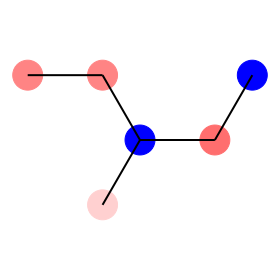

CC(C)CC(C)C


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


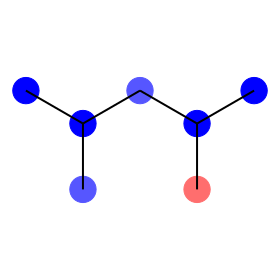

C=CCCC


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


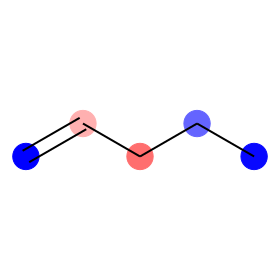

C1=CCCCC1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


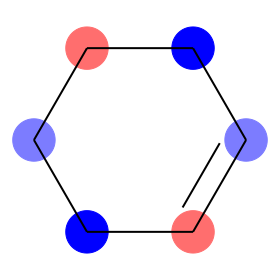

C=CCC=C


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


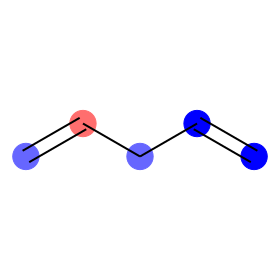

C1=CC=CCC=C1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


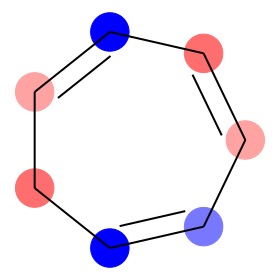

C#CCCCCCC


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


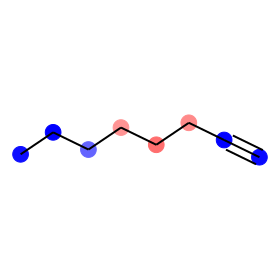

CCc1ccccc1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


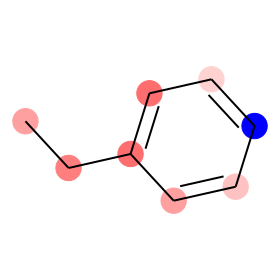

Cc1cc(C)cc(C)c1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


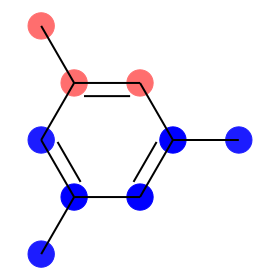

c1ccc2c(c1)CCC2


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


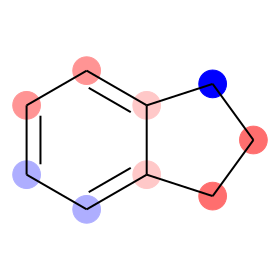

RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


CC(C)Cc1ccccc1


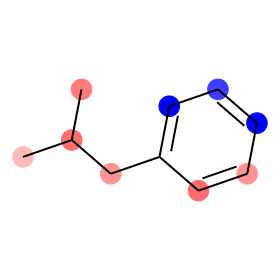

CCCCCCc1ccccc1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


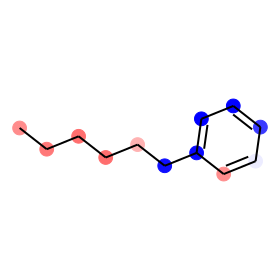

c1ccc(CCc2ccccc2)cc1


RDKit WARNING: [20:16:59] The new font size 1 is below the current minimum (6).


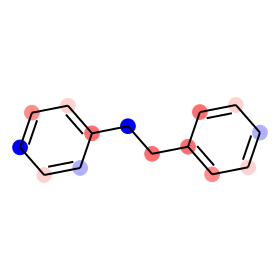

CCc1cccc2ccccc12


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


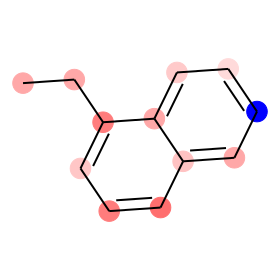

Cc1cc(C)c2ccccc2c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


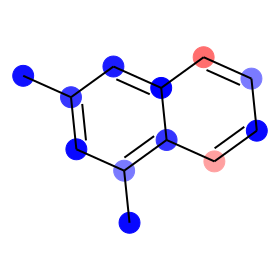

c1ccc2cc3ccccc3cc2c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


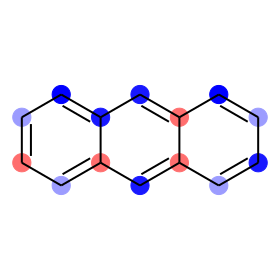

Cc1c2ccccc2c(C)c2ccccc12


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


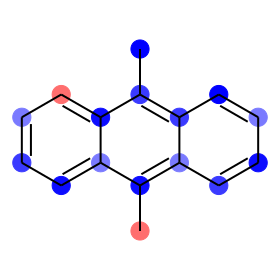

c1ccc2cc3cc4ccccc4cc3cc2c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


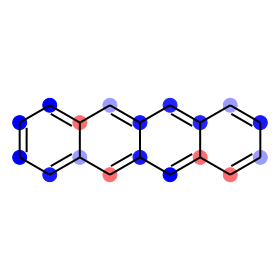

c1ccc2c(c1)ccc1c3ccccc3ccc21


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


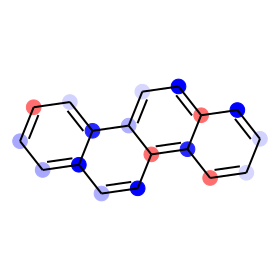

c1ccc2c(c1)ccc1nccnc12


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


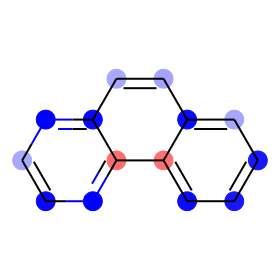

Nc1cc2c3ccccc3ccc2c2ccccc12


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


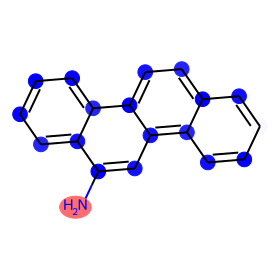

Cc1ccc2cc3c(ccc4ccccc43)c3c2c1CC3


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


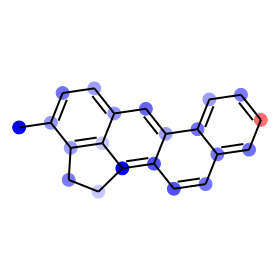

BrCBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


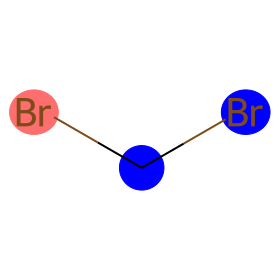

ClC(Cl)(Cl)Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


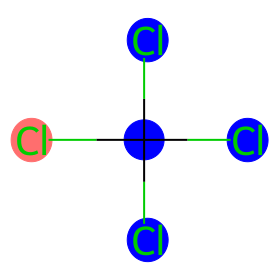

ClCCCl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


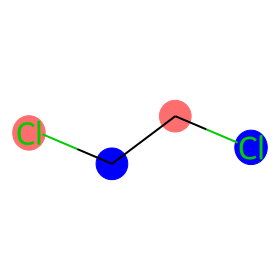

ClC(Cl)C(Cl)Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


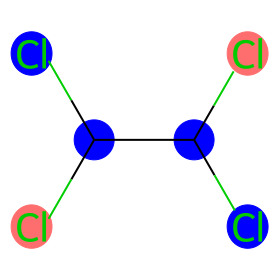

CCCCl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


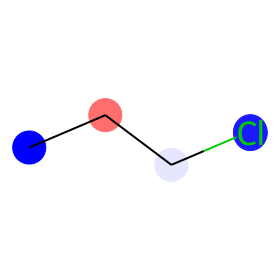

CC(C)I


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


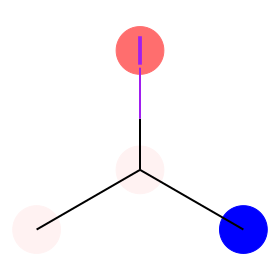

CC(Br)CBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


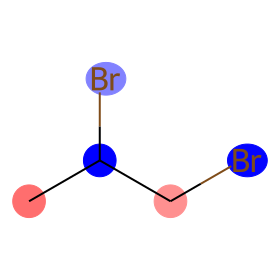

CCCCBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


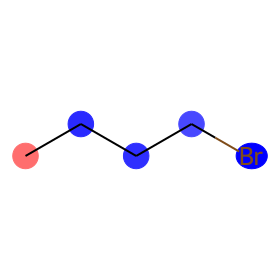

CC(Cl)C(C)Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


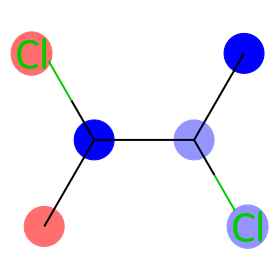

CC(C)CCBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


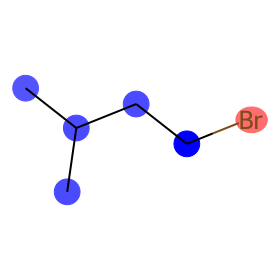

CCCCCCCCBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


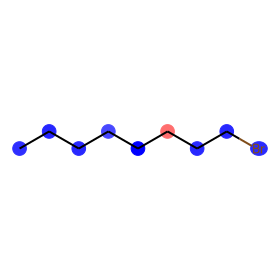

CCCCCCCBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


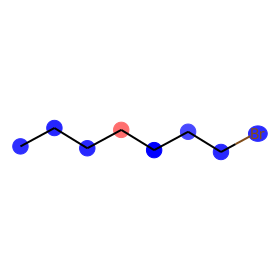

BrC=CBr


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


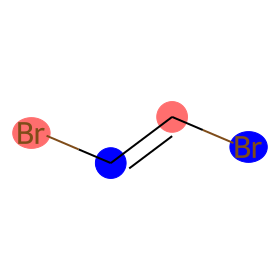

ClC1=C(Cl)C2(Cl)C3C(Cl)C=CC3C1(Cl)C2(Cl)Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


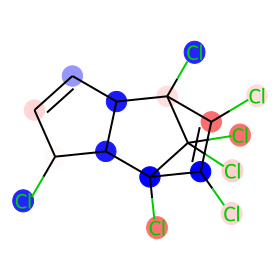

ClC(Cl)=C(Cl)C(Cl)=C(Cl)Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


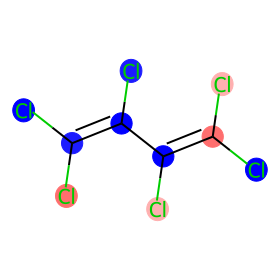

Brc1ccccc1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


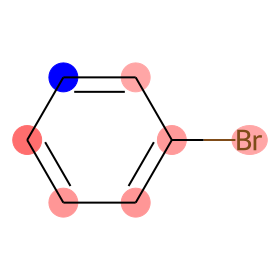

Clc1ccccc1Br


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


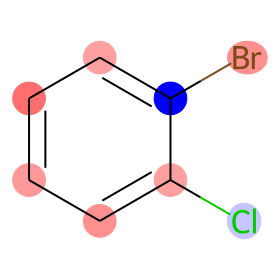

Brc1cccc(Br)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


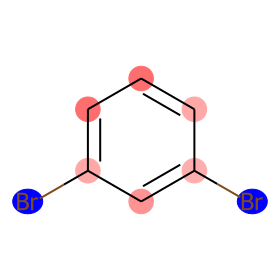

Brc1ccc(Br)c(Br)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


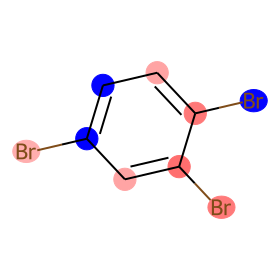

Clc1cc(Cl)c(Cl)c(Cl)c1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


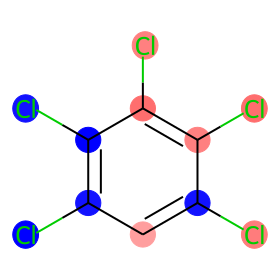

Fc1cccc(F)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


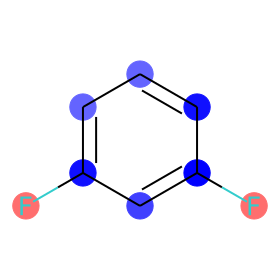

Clc1ccc(-c2ccccc2)cc1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


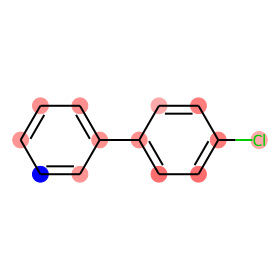

Clc1ccc(-c2ccccc2Cl)cc1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


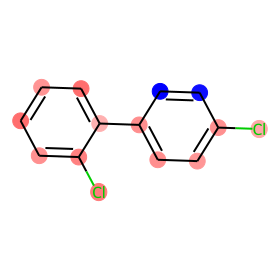

Clc1ccc(Cl)c(-c2ccccc2Cl)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


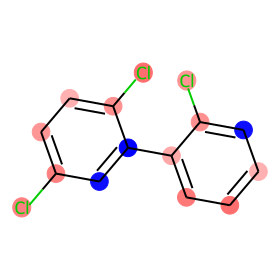

Clc1ccc(-c2ccccc2Cl)cc1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


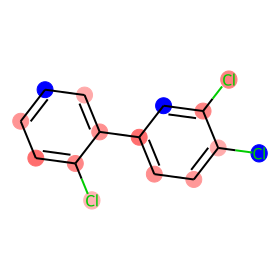

Clc1cc(-c2ccccc2)c(Cl)c(Cl)c1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


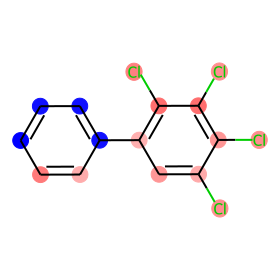

Clc1ccc(Cl)c(-c2c(Cl)cccc2Cl)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


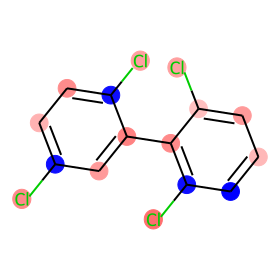

Clc1ccc(Cl)c(-c2ccc(Cl)c(Cl)c2Cl)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


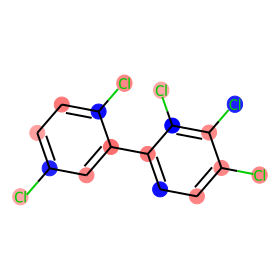

Clc1c(Cl)c(Cl)c(-c2ccccc2)c(Cl)c1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


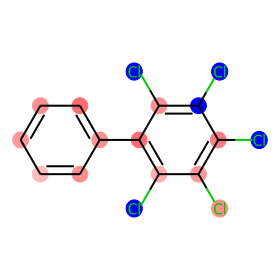

Clc1ccc(Cl)c(-c2cc(Cl)c(Cl)c(Cl)c2Cl)c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


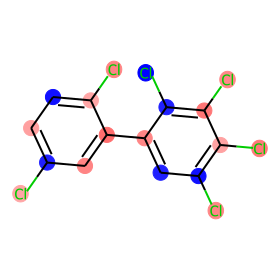

Clc1ccc(-c2ccc(Cl)c(Cl)c2Cl)c(Cl)c1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


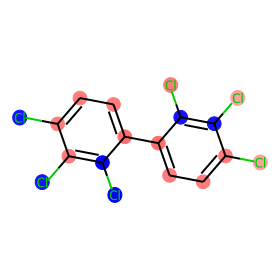

Clc1cc(Cl)c(Cl)c(-c2c(Cl)c(Cl)cc(Cl)c2Cl)c1Cl


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


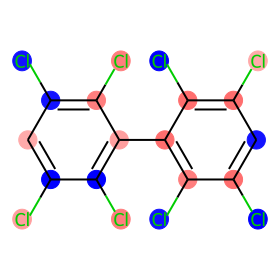

RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


Clc1ccc(C(c2ccc(Cl)cc2)C(Cl)Cl)cc1


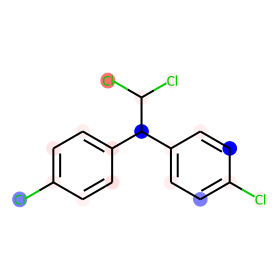

Brc1ccc2ccccc2c1


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


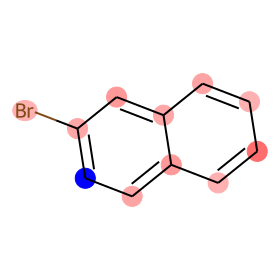

CCCC(C)O


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


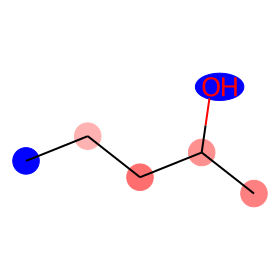

CC(C)(C)CO


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


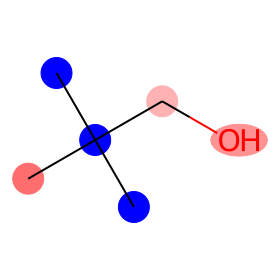

CC(C)C(C)CO


RDKit WARNING: [20:17:00] The new font size 1 is below the current minimum (6).


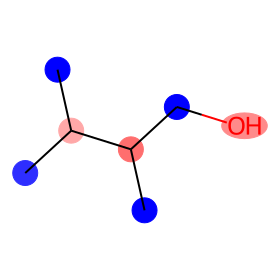

CC(C)CCCO


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


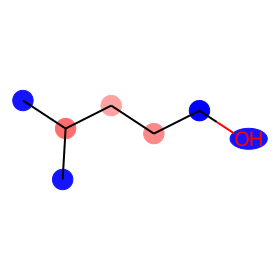

CC(O)C(C)(C)C


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


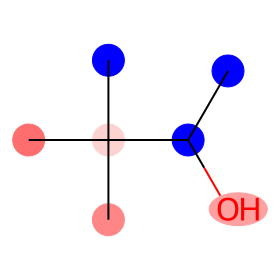

CCCCCC(C)O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


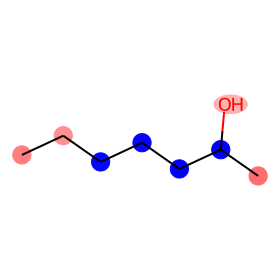

CC(C)CC(C)CO


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


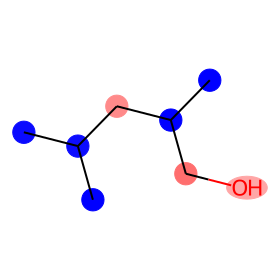

CCC(C)(O)C(C)C


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


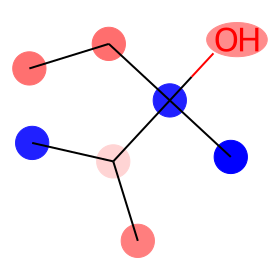

CC(C)(C)C(C)(C)O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


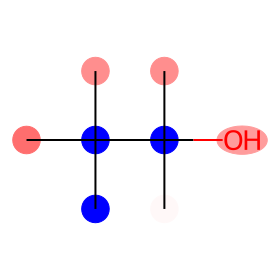

RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


CCCCC(C)(O)CC


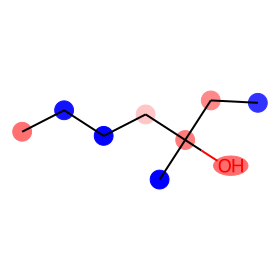

CCCCCCCCCCO


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


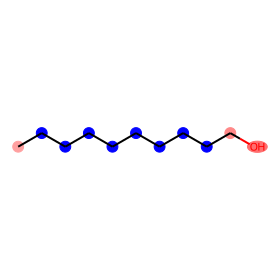

Cc1ccc(CO)cc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


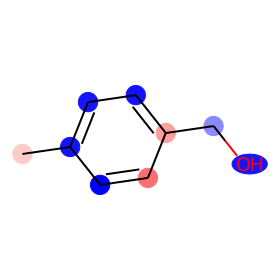

Oc1ccccc1O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


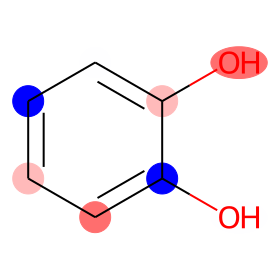

Cc1cccc(O)c1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


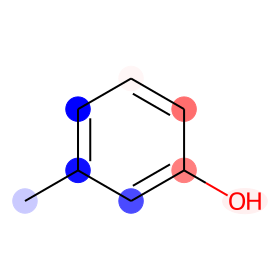

Cc1ccc(C(C)C)c(O)c1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


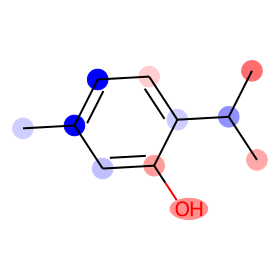

Oc1ccc2ccccc2c1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


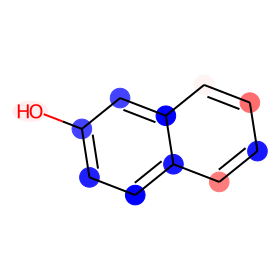

CCCC=O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


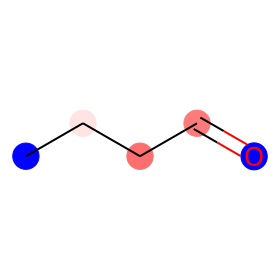

CCCCCCCCC=O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


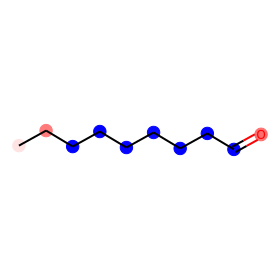

RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


O=Cc1ccco1


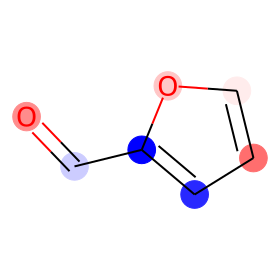

RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


O=C1CCCCC1


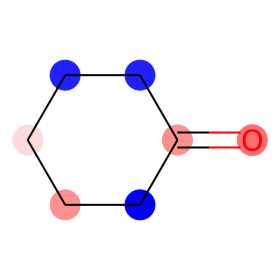

CCCCCCCC(C)=O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


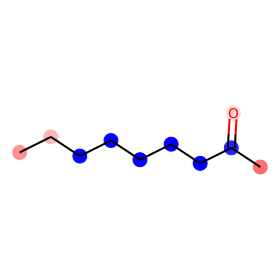

RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


O=C1C=CC(=O)C=C1


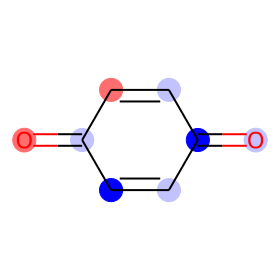

O=C(c1ccccc1)c1ccccc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


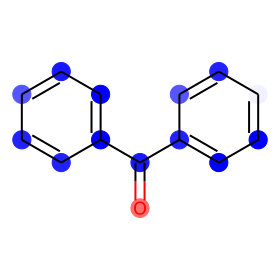

O=C(O)CCC(=O)O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


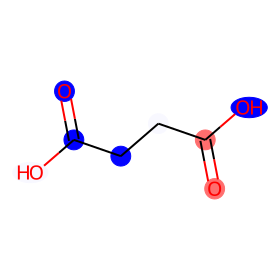

CCCCCCCCCC(=O)O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


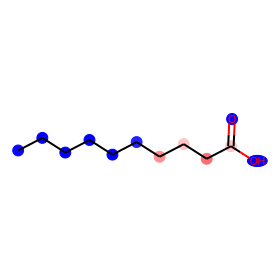

Cc1cccc(C(=O)O)c1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


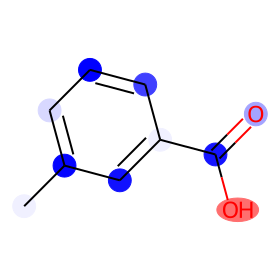

O=C(O)C=Cc1ccccc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


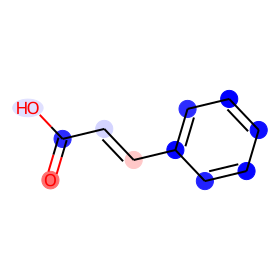

O=C(O)Cc1cccc2ccccc12


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


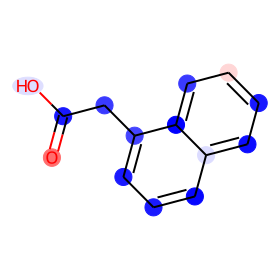

O=C(O)C(c1ccccc1)c1ccccc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


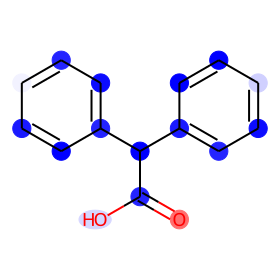

CCCCCCCCCCCCCC(=O)O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


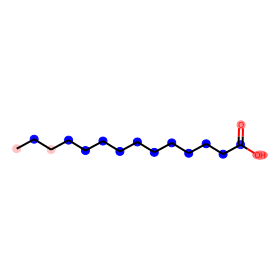

CCOC=O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


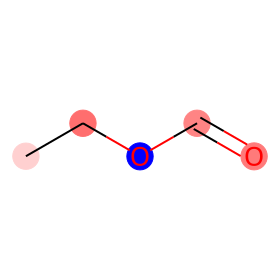

CCOC(=O)CC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


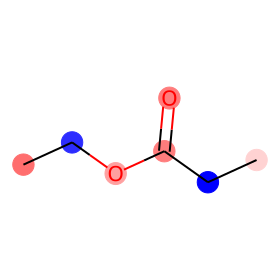

CCCC(=O)OCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


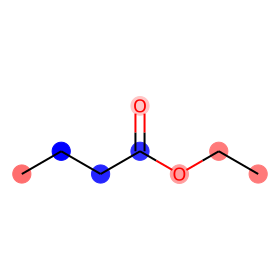

CCCOC(=O)CCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


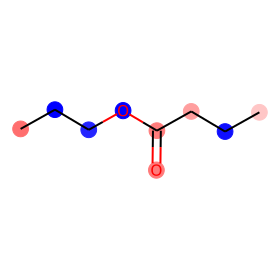

CCCCCC(=O)OCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


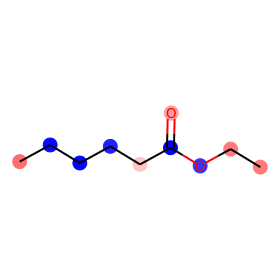

CCCCCCCCC(=O)OCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


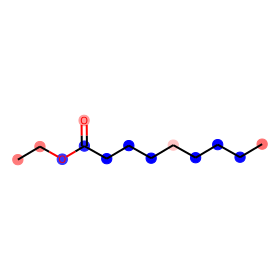

COC(=O)c1ccccc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


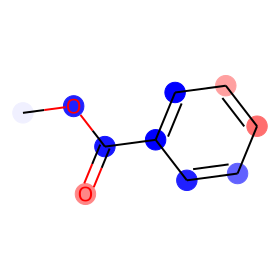

CCCCOC(=O)c1ccccc1C(=O)OCCCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


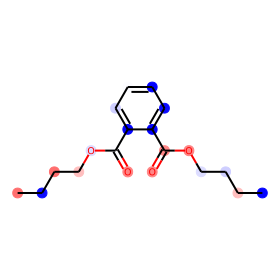

CCOCC


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


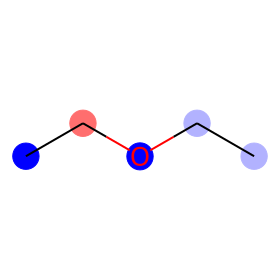

COC(C)(C)C


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


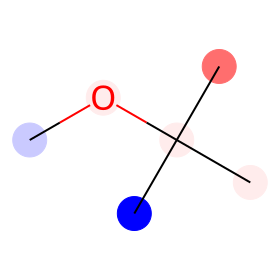

RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


CCCOC(C)C


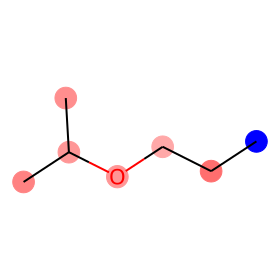

COc1ccccc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


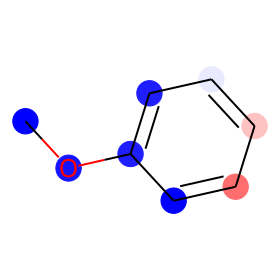

c1ccc(C2CO2)cc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


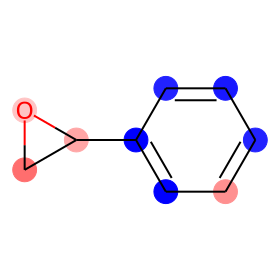

CCCCOCCO


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


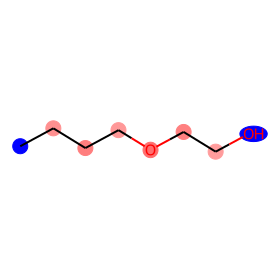

CC12CCC(=O)C=C1CCC1C2C(O)CC2(C)C1CCC2(O)C(=O)CO


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


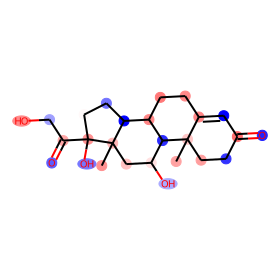

CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)C=CC4(C)C3C(O)CC21C


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


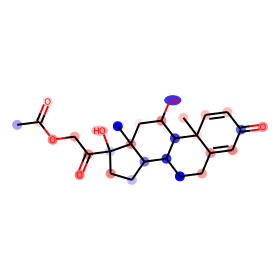

CC12CCC(=O)C=C1CCC1C2CCC2(C)C(C(=O)CO)CCC12


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


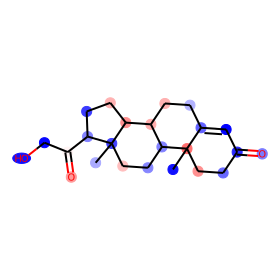

CC12CCC(=O)C=C1CCC1C3CCC(O)(C(=O)CO)C3(C)CC(O)C12F


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


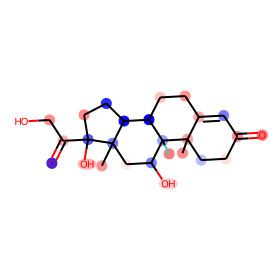

O=C(O)c1ccccc1O


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


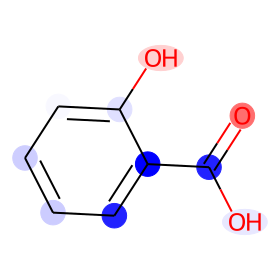

CCOC(=O)c1ccc(O)cc1


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


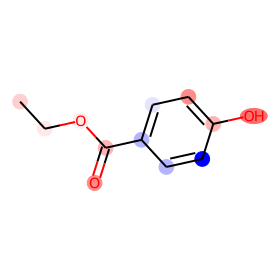

Oc1ccccc1Cl


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


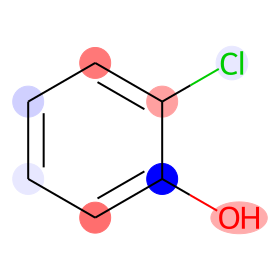

Oc1c(Cl)cc(Cl)cc1Cl


RDKit WARNING: [20:17:01] The new font size 1 is below the current minimum (6).


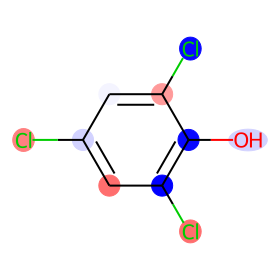

O=C(O)c1ccc(Cl)cc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


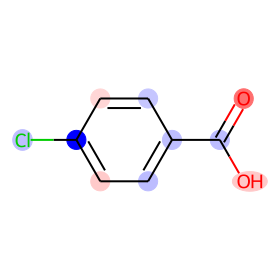

ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


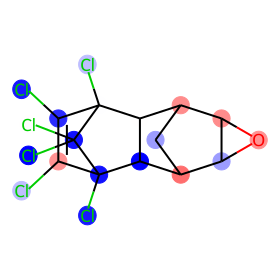

CCCCCCN


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


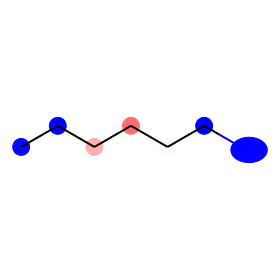

CCCCCCCCN


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


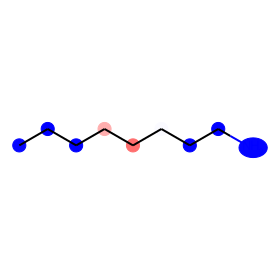

CNc1ccccc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


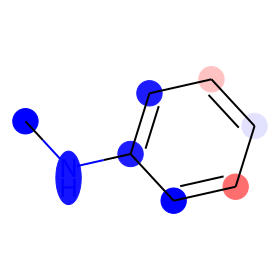

CN(C)c1ccccc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


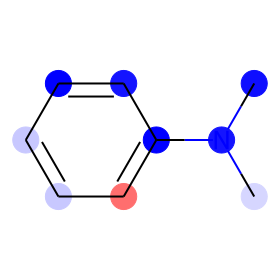

Nc1cccc2ccccc12


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


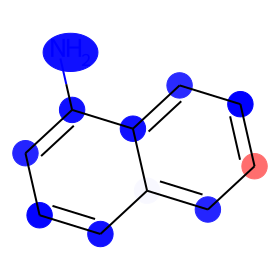

RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


Cc1ccc(C)nc1


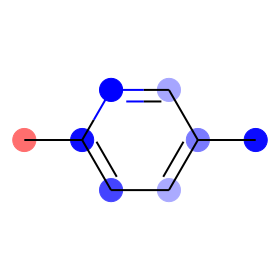

c1ccc2cnccc2c1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


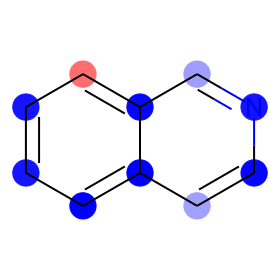

O=C(O)c1cccnc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


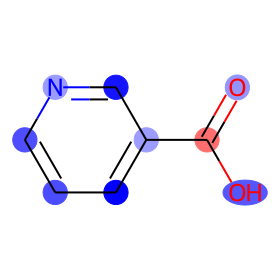

Cc1cc(N)nc(C)n1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


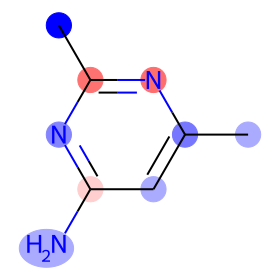

c1cc[nH]c1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


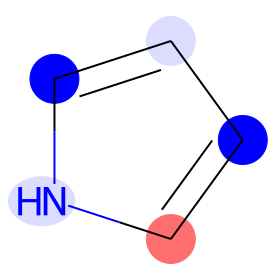

Sc1nc2ccccc2s1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


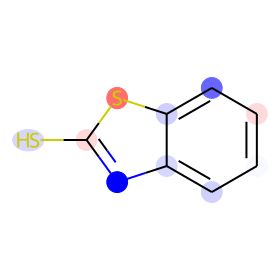

Oc1ccc2ncccc2c1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


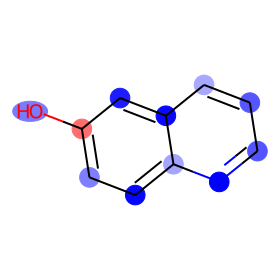

CCC1(CC)C(=O)NC(=O)N(C)C1=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


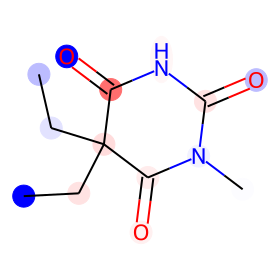

CN1C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


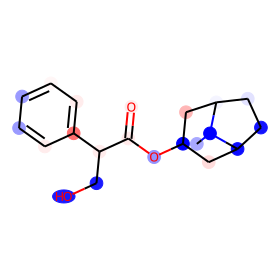

NS(=O)(=O)c1cc(C(=O)O)c(NCc2ccco2)cc1Cl


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


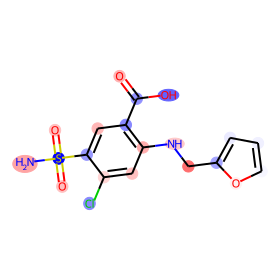

CCC1(CCC(C)C)C(=O)NC(=O)NC1=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


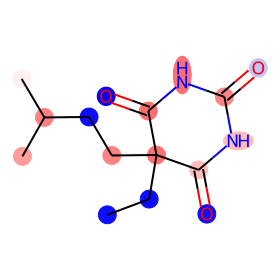

OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


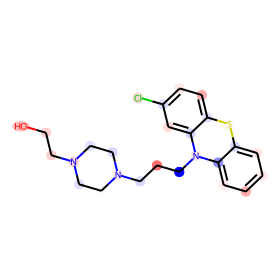

CC(=O)Nc1nnc(S(N)(=O)=O)s1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


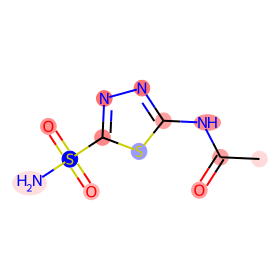

COC(=O)C1=CCCN(C)C1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


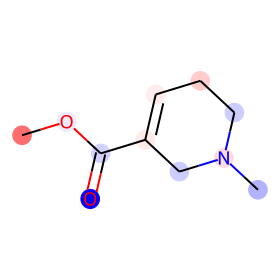

CCC1(C(C)C)C(=O)NC(=O)NC1=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


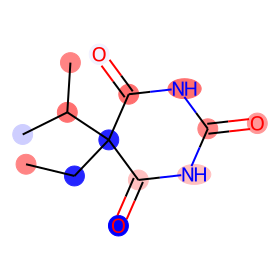

COc1ccc(NS(=O)(=O)c2ccc(N)cc2)nn1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


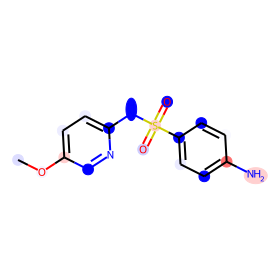

CCN(CC)C(=S)SSC(=S)N(CC)CC


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


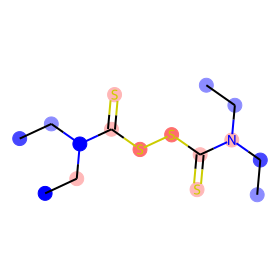

COC1=CC(=O)CC(C)C12Oc1c(Cl)c(OC)cc(OC)c1C2=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


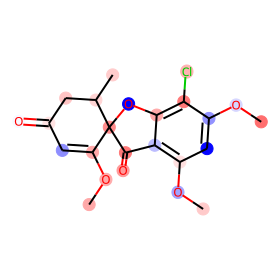

Cc1nnc(NS(=O)(=O)c2ccc(N)cc2)s1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


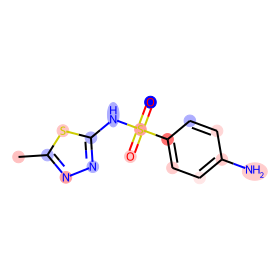

COc1cc2c(cc1OC)C13CCN4CC5=CCOC6CC(=O)N2C1C6C5CC43


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


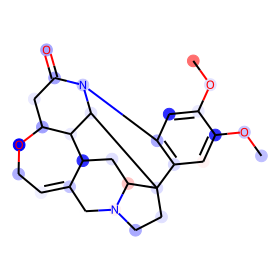

Nc1ccc(S(=O)(=O)Nc2ccnn2-c2ccccc2)cc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


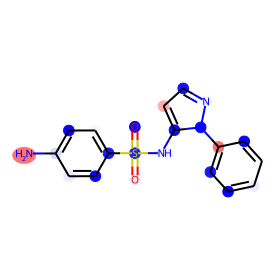

Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


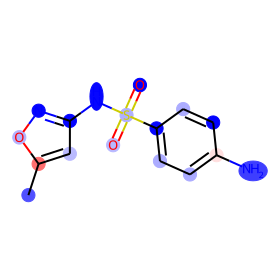

COc1cc(NS(=O)(=O)c2ccc(N)cc2)nc(C)n1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


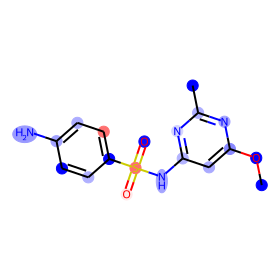

CC1=C(C(=O)Nc2ccccc2)S(=O)(=O)CCO1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


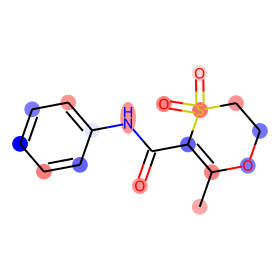

CC(C(=O)O)c1cccc(C(=O)c2ccccc2)c1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


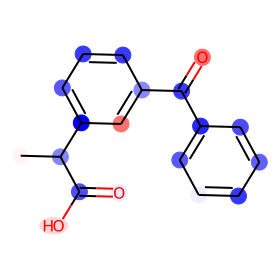

CNC(=NC#N)NCCSCc1[nH]cnc1C


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


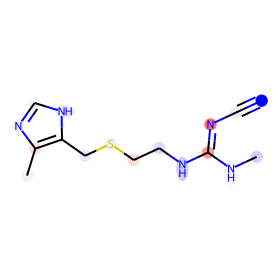

Cn1c(=O)c2c(ncn2C)n(C)c1=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


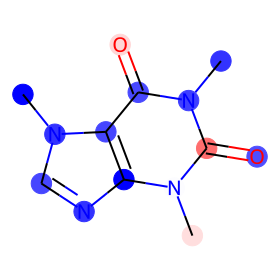

CC1CC(C)C(=O)C(C(O)CC2CC(=O)NC(=O)C2)C1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


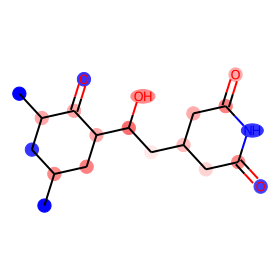

C1CNCCN1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


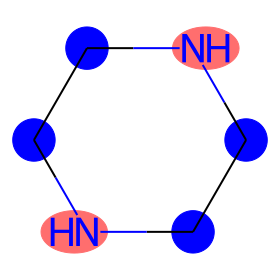

O=C1CNC(=O)N1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


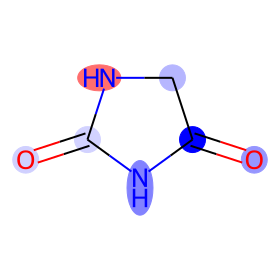

CN1CCCC1=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


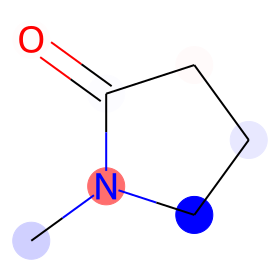

RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


Nc1ccccc1O


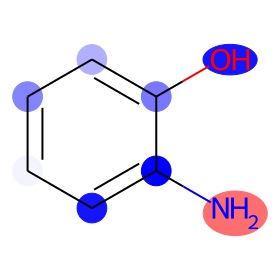

CCOC(N)=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


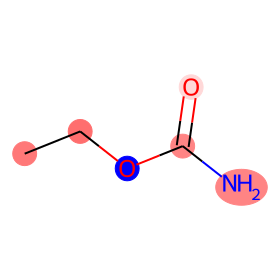

CNC(=O)Oc1cccc2ccccc12


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


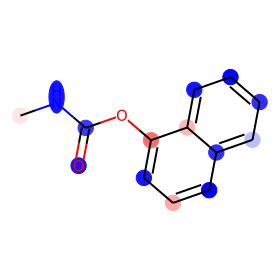

CNC(N)=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


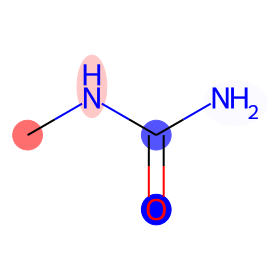

C=CC(N)=O


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


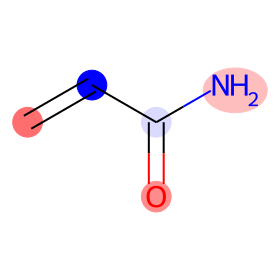

CC(=O)Nc1ccc(O)cc1


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


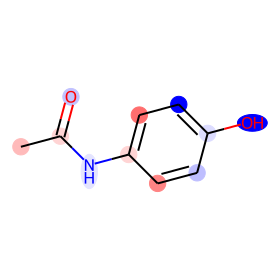

CC(C)[N+](=O)[O-]


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


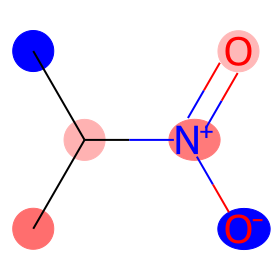

O=[N+]([O-])c1cccc2ccccc12


RDKit WARNING: [20:17:02] The new font size 1 is below the current minimum (6).


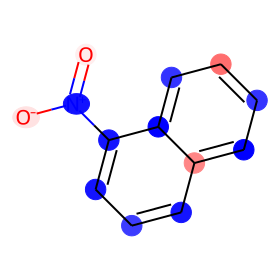

O=C(O)c1ccc([N+](=O)[O-])cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


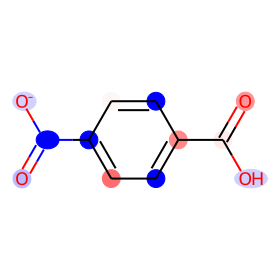

Nc1ccccc1[N+](=O)[O-]


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


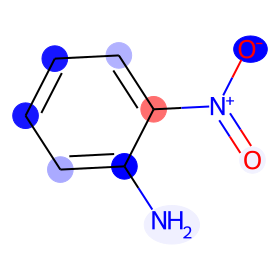

Nc1cccc(Cl)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


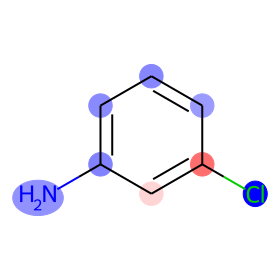

N#Cc1c(Cl)c(Cl)c(Cl)c(C#N)c1Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


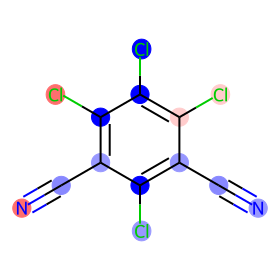

Cn1cc(-c2ccccc2)c(=O)c(-c2cccc(C(F)(F)F)c2)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


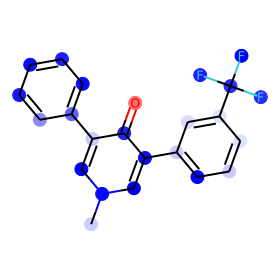

CCC(=O)Nc1ccc(Cl)c(Cl)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


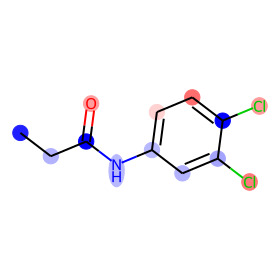

CCc1cccc(CC)c1N(COC)C(=O)CCl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


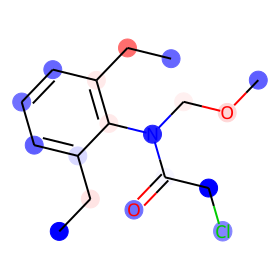

RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


CCS


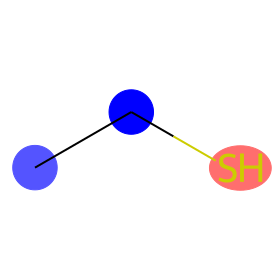

NC(N)=S


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


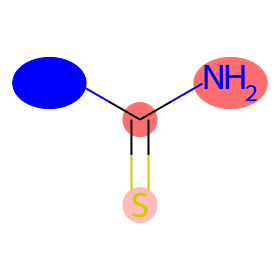

COC(=O)NS(=O)(=O)c1ccc(N)cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


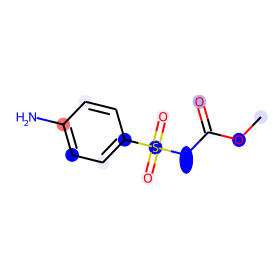

COP(=O)(OC)C(O)C(Cl)(Cl)Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


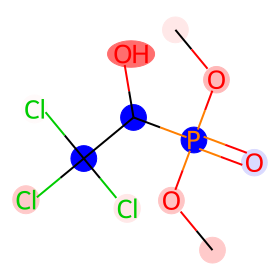

COP(=S)(OC)Oc1ccc(SC)c(C)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


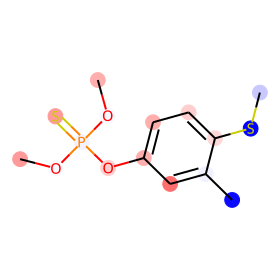

COP(=S)(OC)Oc1ccc([N+](=O)[O-])c(C)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


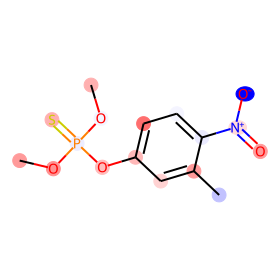

COP(=S)(OC)Oc1cc(Cl)c(I)cc1Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


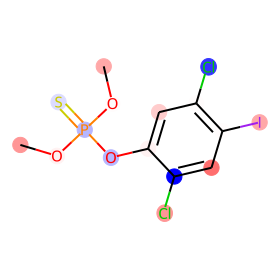

CC(CCC(=O)O)C1CCC2C3C(O)C(O)C4CC(O)CCC4(C)C3CCC12C


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


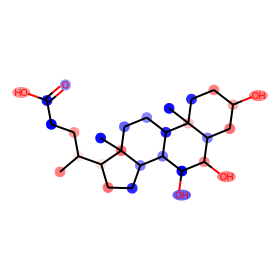

CC1CNCCN1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


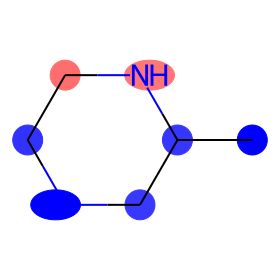

CC(=O)Nc1ccc(Cl)cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


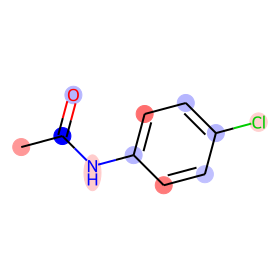

CC(=O)Nc1ccc([N+](=O)[O-])cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


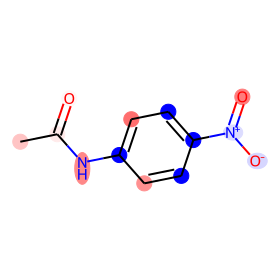

COc1ccc2c(c1OC)C(=O)OC2C1c2cc3c(cc2CCN1C)OCO3


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


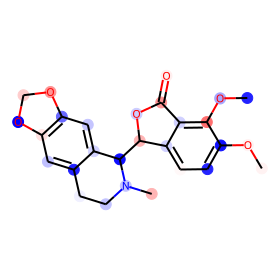

O=C1CN=C(c2ccccc2)c2cc([N+](=O)[O-])ccc2N1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


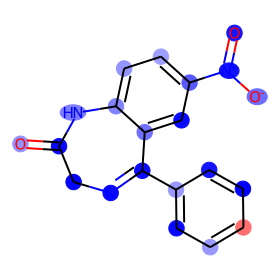

Oc1ccc(Cl)cc1Cc1cc(Cl)ccc1O


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


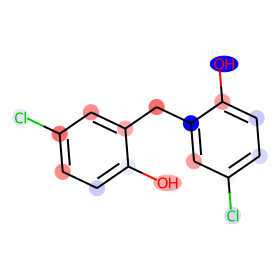

Nc1c(Cl)c(Cl)nc(C(=O)O)c1Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


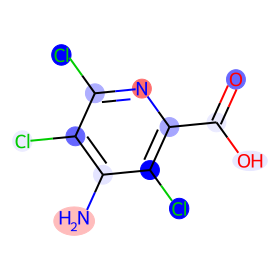

NC(Cc1ccc(O)cc1)C(=O)O


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


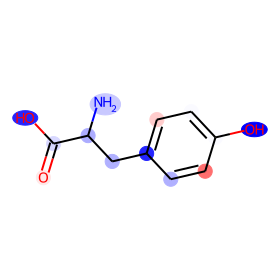

CC(C)N(C(=O)SCC(Cl)=CCl)C(C)C


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


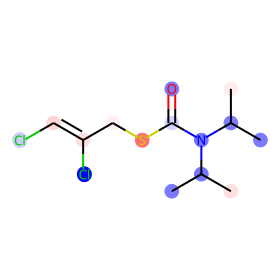

CCCCOC(=O)c1ccc(O)cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


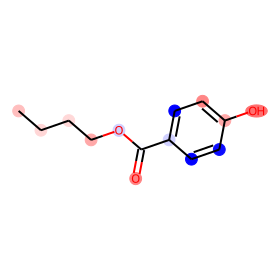

CCCOC(=O)c1cc(O)c(O)c(O)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


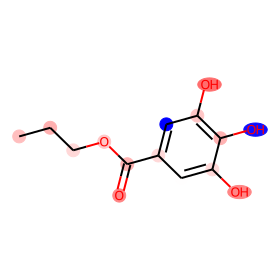

CCCCCOC(=O)c1ccc(N)cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


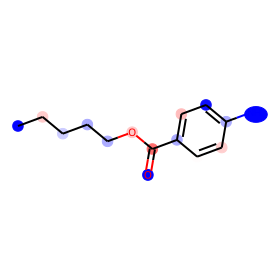

RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


c1ccc(-c2ccc(-c3ccccc3)cc2)cc1


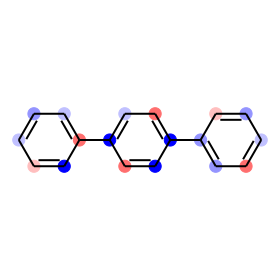

CC(=O)Nc1ccccc1Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


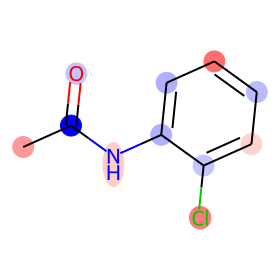

CCC1CCCCN1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


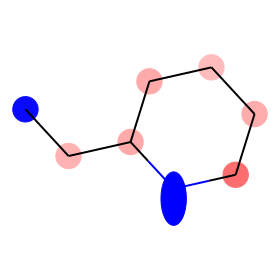

C=CCc1ccc(OC)cc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


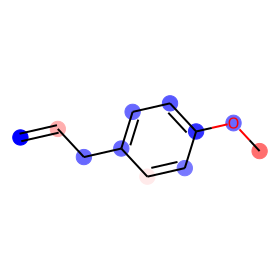

COc1c(O)c(Cl)c(Cl)c(Cl)c1Cl


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


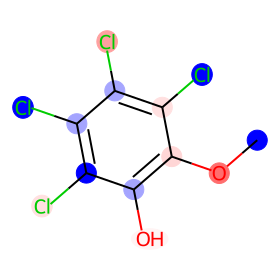

O=C1CSC(=S)N1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


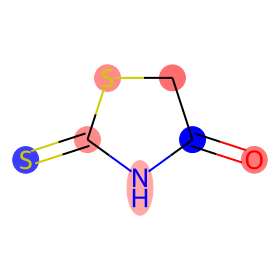

Ic1[nH]c(I)c(I)c1I


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


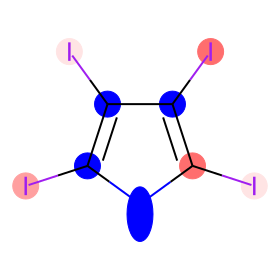

Nc1cc[nH]c(=O)n1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


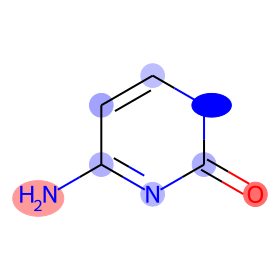

NC(=O)CC(N)C(=O)O


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


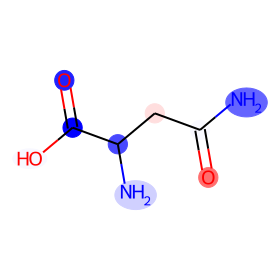

CCS(=O)(=O)CC


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


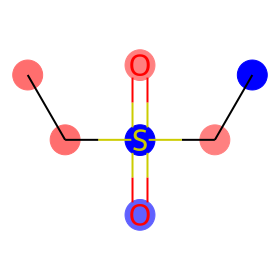

Oc1ccncc1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


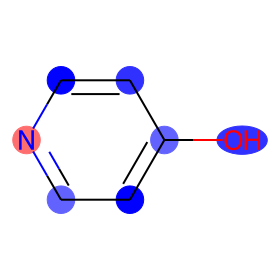

Cc1cc(=O)[nH]c(=O)[nH]1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


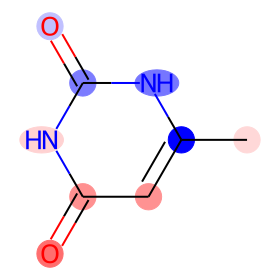

OC1COC(O)C(O)C1O


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


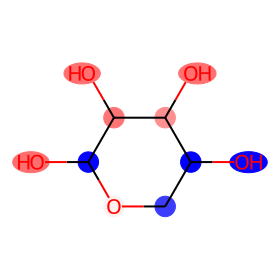

Sc1ncnc2nccnc12


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


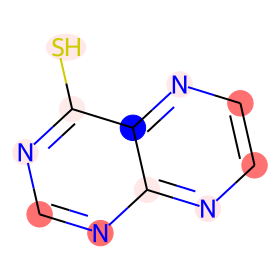

RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


NS(=O)(=O)c1ccccc1


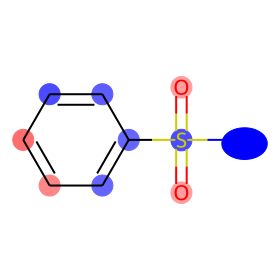

CN(C)C(=S)SSC(=S)N(C)C


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


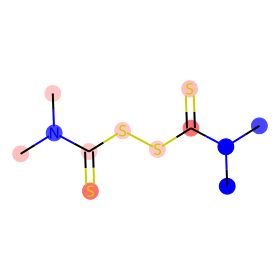

CC1CNC(C)CN1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


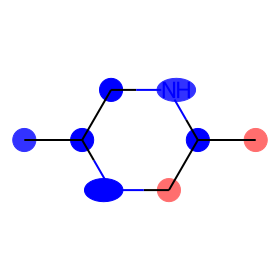

O=C(O)c1cccc(I)c1


RDKit WARNING: [20:17:03] The new font size 1 is below the current minimum (6).


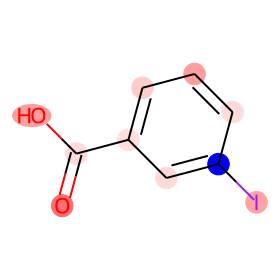

COc1ncnc2nccnc12


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


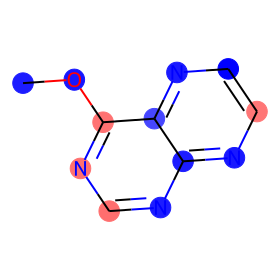

CSc1cnc2ncncc2n1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


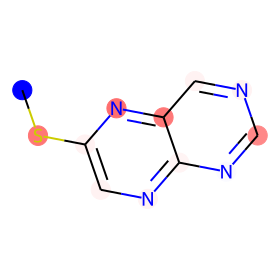

CCCc1cc(=O)[nH]c(=S)[nH]1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


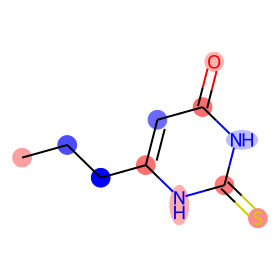

Clc1c(Cl)c(Cl)c2nccnc2c1Cl


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


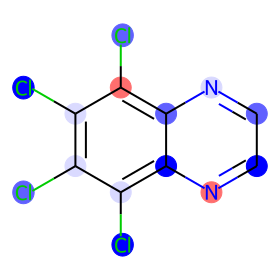

RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


O=C(O)COc1ccc(Cl)cc1Cl


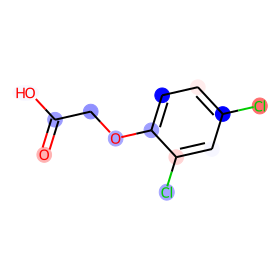

COC(=O)c1ccccc1O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


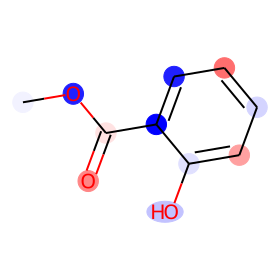

CNc1ccccc1C(=O)O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


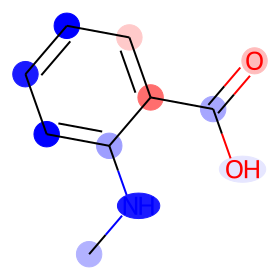

CCOc1ccccc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


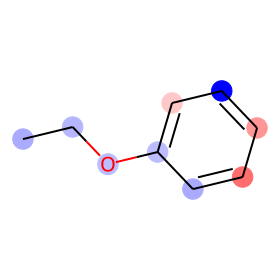

NCCc1ccc(O)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


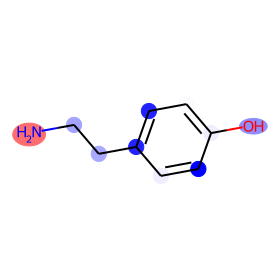

RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


CC(=O)CC(=O)CC(C)C


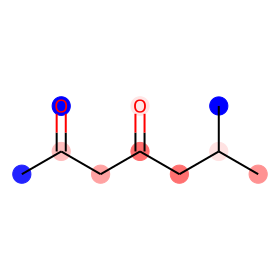

CC1CCCCC1C


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


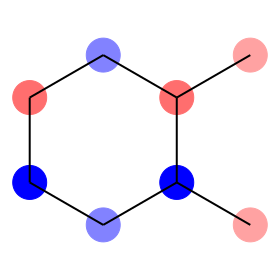

O=C(O)Cn1c(=O)sc2cccc(Cl)c21


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


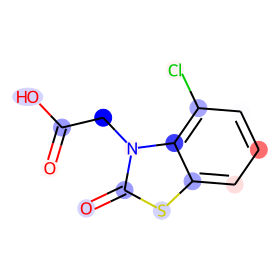

CC(Oc1cccc(Cl)c1)C(=O)O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


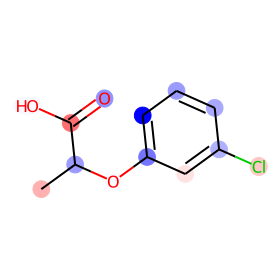

COC(=O)c1ccc(OC)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


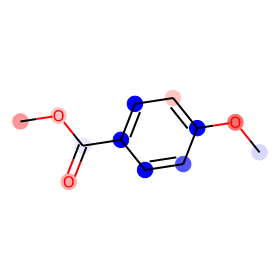

CCOc1ccc(NC(N)=O)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


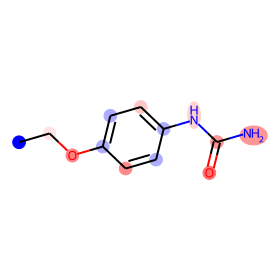

CCCCCCCCC(=O)O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


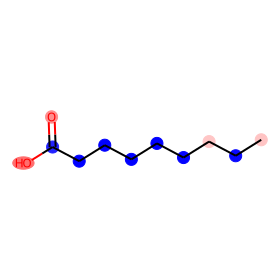

Nc1cnn(-c2ccccc2)c(=O)c1Cl


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


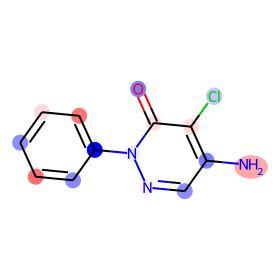

Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


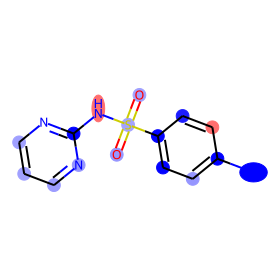

CC(=O)Nc1ccc(OC(C)=O)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


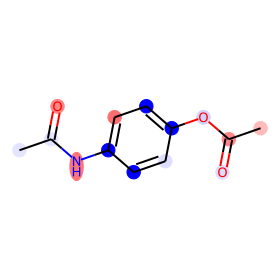

Oc1ccc2c(c1)CCCC2


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


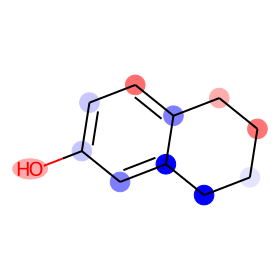

Cc1ccc(C(C)C)cc1O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


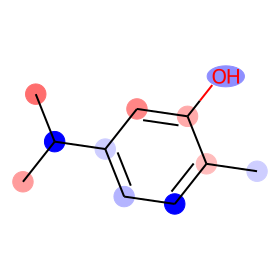

CC12CCC(C1)C(C)(C)C2=O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


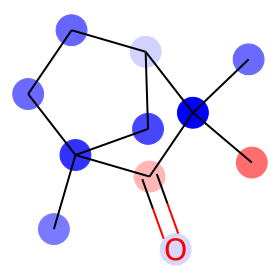

CC1CCC(C(C)C)C(=O)C1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


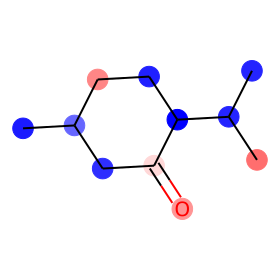

Cc1cc(C)c2ccccc2n1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


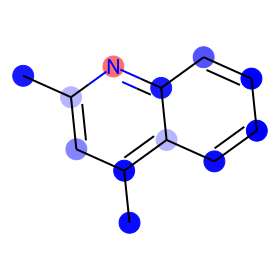

CCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)c(N)c1[N+](=O)[O-]


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


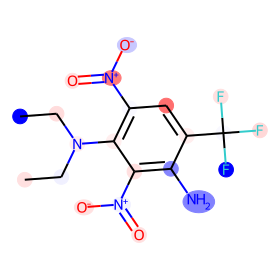

COC(=O)C1C2C=CC(C2)C1C(=O)OC


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


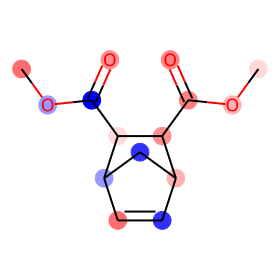

CCCCNC(=O)NS(=O)(=O)c1ccccc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


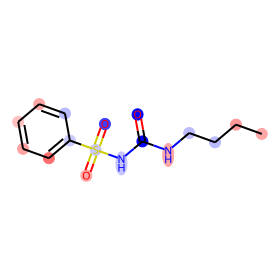

CCCCc1c(C)nc(NCC)nc1O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


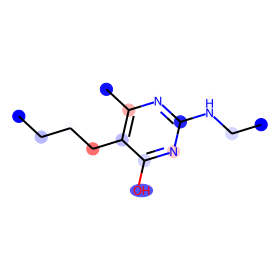

O=C1C(Cl)=C(NC(=O)C(Cl)Cl)C(=O)c2ccccc21


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


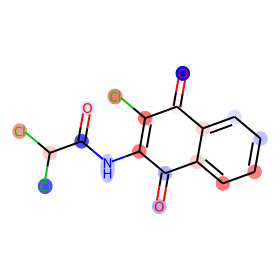

O=C1C=CC(O)(c2cc(O)ccc2O)C=C1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


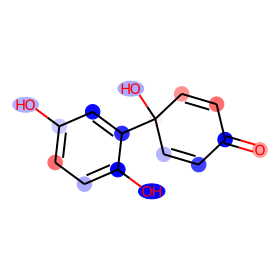

CCC(N)Cc1c[nH]c2ccccc12


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


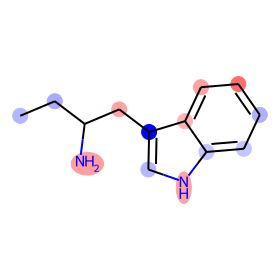

CCCCCCc1ccc(O)cc1O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


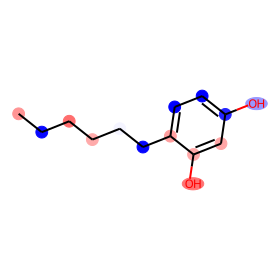

O=C(Nc1ccccc1)c1ccccc1I


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


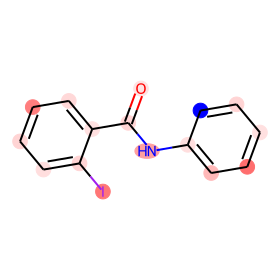

CCCCN(CC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-]


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


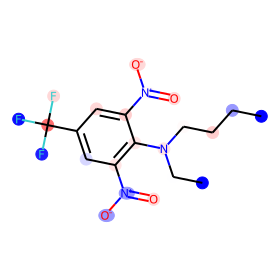

CCCCc1c(C)nc(NCC)nc1OS(=O)(=O)N(C)C


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


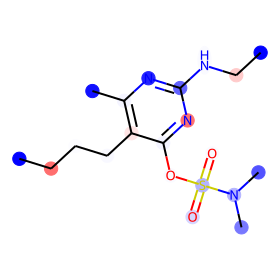

Clc1ccc(C(c2ccccc2Cl)C(Cl)(Cl)Cl)cc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


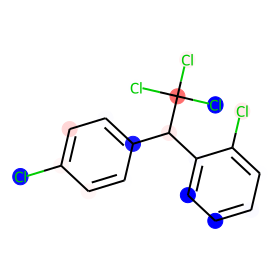

O=C(O)c1ccccc1-c1ccccc1C(=O)O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


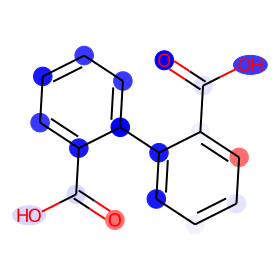

O=C(Oc1ccccc1)c1ccccc1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


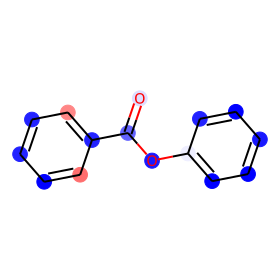

CC(C)(C)C(=O)C1C(=O)c2ccccc2C1=O


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


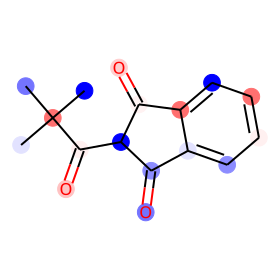

CN(C)CCN(Cc1cccs1)c1ccccn1


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


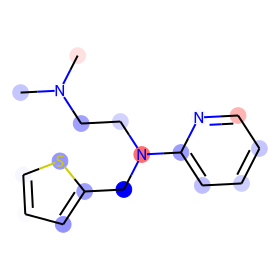

O=c1c(O)c(-c2ccc(O)cc2O)oc2cc(O)cc(O)c12


RDKit WARNING: [20:17:04] The new font size 1 is below the current minimum (6).


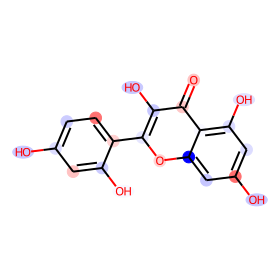

NS(=O)(=O)c1cc2c(cc1C(F)(F)F)NC(Cc1ccccc1)NS2(=O)=O


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


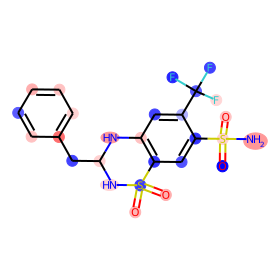

CC(C)Oc1cc(-n2nc(C(C)(C)C)oc2=O)c(Cl)cc1Cl


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


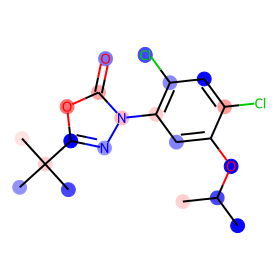

CCc1cccc(C)c1N(C(=O)CCl)C(C)COC


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


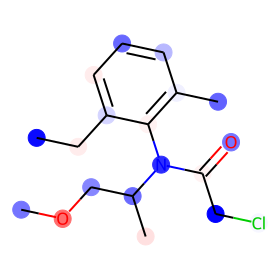

O=C1C=C2CC3(O)COc4c(ccc(O)c4O)C3=C2C=C1O


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


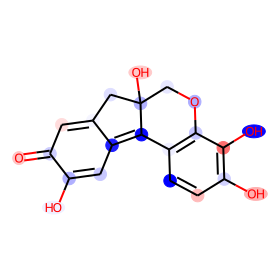

OC(c1ccc(Cl)cc1)(c1cncnc1)c1ccccc1Cl


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


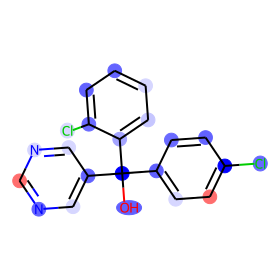

c1ccc(CN(CC2=NCCN2)c2ccccc2)cc1


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


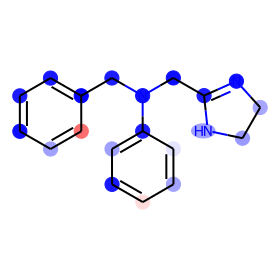

C=CC(c1ccc(O)cc1)C(C=C)c1ccc(O)cc1


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


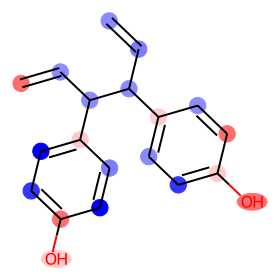

CCC(c1ccc(O)cc1)C(CC)c1ccc(O)cc1


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


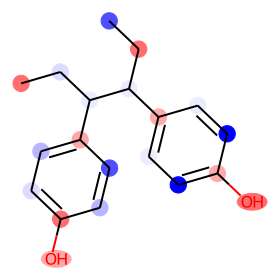

CCC1CN2CCC1CC2C(O)c1ccnc2ccccc12


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


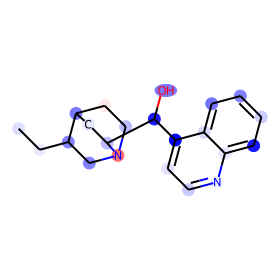

CC12CCC3C(CCC4CC5SC5CC43C)C1CCC2O


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


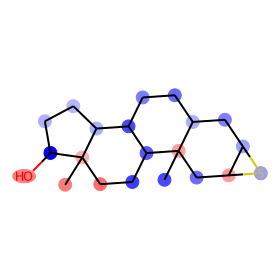

RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


CN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1


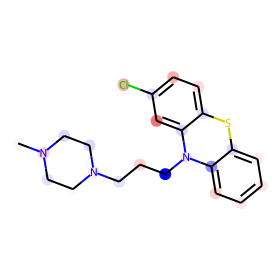

RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1


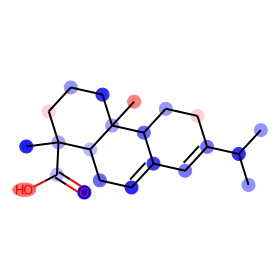

C#CC1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3CCC21C


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


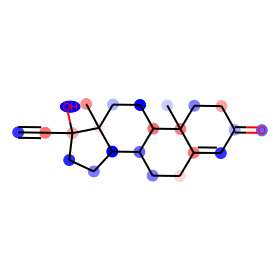

CCOC(=O)C(c1c(O)c2ccccc2oc1=O)c1c(O)c2ccccc2oc1=O


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


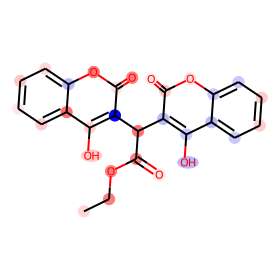

RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


NCCC(O)C(=O)NC1CC(N)C(OC2OC(CN)C(O)C(O)C2O)C(O)C1OC1OC(CO)C(O)C(N)C1O


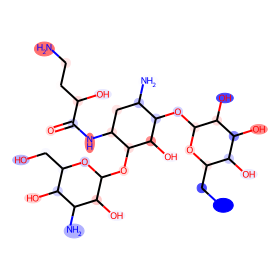

COc1ccc(Cl)cc1C(=O)NCCc1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


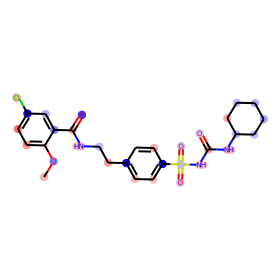

CC1CCC2(OC1)OC1CC3C4CC=C5CC(O)CCC5(C)C4CCC3(C)C1C2C


RDKit WARNING: [20:17:05] The new font size 1 is below the current minimum (6).


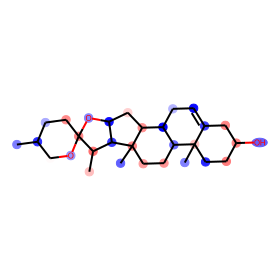

In [3]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from IPython.display import display
import matplotlib
import matplotlib.cm as cm
import torch
from rdkit import Chem


def drawmol(idx, dataset, timestep):
    smiles, graph, _ = dataset[idx]
    print(smiles)
    bg = dgl.batch([graph])
    atom_feats, bond_feats = bg.ndata['hv'], bg.edata['he']
    if torch.cuda.is_available():
        print('use cuda')
        bg.to(torch.device('cuda:0'))
        atom_feats = atom_feats.to('cuda:0')
        bond_feats = bond_feats.to('cuda:0')

    _, atom_weights = eval_model(bg, atom_feats, bond_feats, get_node_weight=True)
    assert timestep < len(atom_weights), 'Unexpected id for the readout round'
    atom_weights = atom_weights[timestep]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
    cmap = cm.get_cmap('bwr')
    plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(bg.number_of_nodes())}

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)
    op = drawer.drawOptions()

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=range(bg.number_of_nodes()),
                        highlightBonds=[],
                        highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:', '')
    if torch.cuda.is_available():
        atom_weights = atom_weights.to('cpu')
    return (Chem.MolFromSmiles(smiles), atom_weights.data.numpy(), svg)


target = test_loader.dataset
for i in range(len(target)):
    mol, aw, svg = drawmol(i, target, 0)
    display(SVG(svg))
